### ADS 509 Final Project Topic Modeling on Amazon Kitchen Product Reviews submitted by Sai Thiha

In [32]:
import warnings

# Suppress warning messages

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# classification
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# topic modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Visualization
import pyLDAvis.sklearn

# Flask
from flask import Flask

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
def clean(text):
# convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text) # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

Web scraping from amazon product reviews is performed and code is located in python files in Github https://github.com/saithiha118/ADS_509_text_analytics_project_amazon_product_review/blob/main/readCSVwriteReviews.py
    https://github.com/saithiha118/ADS_509_text_analytics_project_amazon_product_review/blob/main/getASIN.py

In [34]:
silverware_raw = pd.read_csv(r"C:\Users\saith\Documents\msads509\new final project\project_data\silverware_reviews.csv", header=None)
silverware_raw['item'] = 'silverware'
cups_raw = pd.read_csv(r"C:\Users\saith\Documents\msads509\new final project\project_data\cups_reviews.csv", header=None)
cups_raw['item'] = 'cups'
bowl_raw = pd.read_csv(r"C:\Users\saith\Documents\msads509\new final project\project_data\bowl_reviews.csv", header=None)
bowl_raw['item'] = 'bowl'
pan_raw = pd.read_csv(r"C:\Users\saith\Documents\msads509\new final project\project_data\pan_reviews.csv", header=None)
pan_raw['item'] = 'pan'
spatula_raw = pd.read_csv(r"C:\Users\saith\Documents\msads509\new final project\project_data\spatula_reviews.csv", header=None)
spatula_raw['item'] = 'spatula'
foodstorage_raw = pd.read_csv(r"C:\Users\saith\Documents\msads509\new final project\project_data\foodstorage_reviews.csv", header=None)
foodstorage_raw['item'] = 'foodstorage'

df = pd.concat([
    silverware_raw,
    cups_raw,
    bowl_raw,
    pan_raw,
    spatula_raw,
    foodstorage_raw], 
    axis=0)

df = df.rename({0:'review'}, axis=1)
df = df.reset_index()
df = df[['review', 'item']].astype("string")
# df = df.to_frame()
df = df.dropna()
df

,review,item
0,"This set is very basic, which is what I wanted...",silverware
1,My wife and I were surprised by the quality of...,silverware
2,I need more flatware and saw these and thought...,silverware
3,Very nice set of stainless steel.,silverware
4,Can not beat this set for the price! The size/...,silverware
...,...,...
23474,I much prefer this variety set over other rubb...,foodstorage
23475,"The lids are super durable and thick, not the ...",foodstorage
23476,Oh how I love these...got so sick of cracked G...,foodstorage
23477,I use these for pre-cut ingredients for salads...,foodstorage


In [35]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23312 entries, 0 to 23478
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  23312 non-null  string
 1   item    23312 non-null  string
dtypes: string(2)
memory usage: 546.4 KB


,review,item
0,"This set is very basic, which is what I wanted...",silverware
1,My wife and I were surprised by the quality of...,silverware
2,I need more flatware and saw these and thought...,silverware
3,Very nice set of stainless steel.,silverware
4,Can not beat this set for the price! The size/...,silverware
...,...,...
23474,I much prefer this variety set over other rubb...,foodstorage
23475,"The lids are super durable and thick, not the ...",foodstorage
23476,Oh how I love these...got so sick of cracked G...,foodstorage
23477,I use these for pre-cut ingredients for salads...,foodstorage


## Preprocessing Amazon Kitchen Product Review Data
Preprocessing steps for amazon kitchen products review data. Preprocessing is steps are different for inputs to the BERT model

In [36]:
def remove_punctuation(text, exclude=None):
    tw_punct = set(punctuation) # speeds up comparison
    tw_punct = tw_punct - exclude
    
    return ''.join([i for i in text if i not in tw_punct])

def tokenize(text):
    # lowercase as well
    ret = text.lower()
    ret = ret.split(' ')
    # remove potentially empty tokens
    
    return [i for i in ret if i is not '']

def remove_stopwords(tokens, exclude):
    sw = set(stopwords.words("english"))
    sw = sw - exclude
    
    return [i for i in tokens if i not in sw]
    

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    
    return [lemmatizer.lemmatize(i) for i in tokens]


In [37]:
df['BERT_tokens'] = df['review'].apply(remove_punctuation, exclude={"'", '"', '.', ','}).apply(tokenize)

In [38]:
df['lemmatized_tokens'] = df['review'].apply(remove_punctuation, exclude=set()).apply(tokenize).apply(remove_stopwords, exclude=set(['not', 'never', 'nor'])).apply(lemmatize)

In [39]:
df['len'] = df['lemmatized_tokens'].apply(len)


In [40]:
df = df[df['len'] > 5]

### Descriptive statistics

In [41]:
def token_counts(corpus, min_df):
    # Use count vectorizer with a min frequency
    vectorizer = CountVectorizer(min_df=min_df)
    X = vectorizer.fit_transform(corpus)
    
    # get token names and create dataframe
    col_names = vectorizer.get_feature_names()
    # sum across all rows
    return pd.DataFrame(X.toarray(), columns=col_names).sum().to_dict()

def unique_tokens(corpus_1, corpus_2, cutoff=5):
    # get tokens and counts that appear at least n times across all corpora
    # combine corpus1 and corpus2
    min_frq_all = pd.Series(token_counts(corpus_1 + corpus_2, cutoff), name='all')
    
    # Get individual corpus token counts but make sure tokens exist in both
    # to prevent division by zero
    corpus_1_counts = pd.Series(token_counts(corpus_1, 0), name='corpus 1')
    corpus_2_counts = pd.Series(token_counts(corpus_2, 0), name='corpus 2')
    
    # Only include tokens that are in both corpus and meet min frequency
    corpus_1_counts = corpus_1_counts[corpus_1_counts.index.isin(min_frq_all.index)]
    corpus_2_counts = corpus_2_counts[corpus_2_counts.index.isin(min_frq_all.index)]
    
    # tokens ratios in each corpus vs other corpora 
    token_ratios_1 = corpus_1_counts / corpus_1_counts.sum()
    token_ratios_2 = corpus_2_counts / corpus_2_counts.sum()
    
    # Join by tokens
    app_ratio = pd.merge(token_ratios_1, token_ratios_2, how='inner', 
                         left_index=True, right_index=True)
    # (ratio of word in corpus1 / ratio of word in corpus2)
    app_ratio['appearance_ratio_1'] = app_ratio['corpus 1'] / app_ratio['corpus 2']
    
    # have to do it the other way too (ratio corpus2 / ratio corpus1)
    app_ratio['appearance_ratio_2'] = app_ratio['corpus 2'] / app_ratio['corpus 1']
    
    return app_ratio

In [42]:
items = ['silverware',
         'cups',
         'bowl',
         'pan',
         'spatula',
         'foodstorage']
         
for item in items:
    numerator = df[df['item'] == item]['lemmatized_tokens'].apply(lambda x: ' '.join(x)).values.tolist()
    denominator = df[df['item'] != item]['lemmatized_tokens'].apply(lambda x: ' '.join(x)).values.tolist()
    
    comparison = unique_tokens(numerator, denominator, 10)
    comparison.rename(columns={'appearance_ratio_1': '%s ratio' % item, 
                               'appearance_ratio_2': 'ratio of other items'},
                     inplace=True)
    display(comparison.sort_values(['%s ratio' % item], 
                            ascending=False)[['%s ratio' % item, 'ratio of other items']].head(10))

,silverware ratio,ratio of other items
silverware,775.040493,0.001290
serrated,248.723597,0.004021
tableware,177.659712,0.005629
lincoln,168.776726,0.005925
mikasa,82.907866,0.012062
silver,63.167898,0.015831
mirror,59.960153,0.016678
knife,57.739406,0.017319
tarnish,53.297914,0.018762
fork,51.498828,0.019418


,cups ratio,ratio of other items
tumbler,1023.034663,0.000977
acrylic,252.948131,0.003953
drink,227.091211,0.004404
straw,170.037355,0.005881
beverage,158.995968,0.006289
drinking,105.676108,0.009463
keurig,101.179252,0.009883
sip,101.179252,0.009883
12oz,101.179252,0.009883
cup,94.508917,0.010581


,bowl ratio,ratio of other items
lather,892.911256,0.001120
pho,258.814857,0.003864
marble,226.463000,0.004416
ramen,219.992628,0.004546
shaving,177.935214,0.005620
il,148.818543,0.006720
japanese,109.996314,0.009091
shave,107.839524,0.009273
chopstick,93.820386,0.010659
bowl,81.438045,0.012279


,pan ratio,ratio of other items
lodge,505.314340,0.001979
allclad,249.588459,0.004007
tfal,214.127804,0.004670
distribution,212.763932,0.004700
clad,202.534897,0.004937
induction,171.847792,0.005819
anodized,124.794230,0.008013
movie,109.450677,0.009137
saucepan,100.244545,0.009976
12inch,59.328404,0.016855


,spatula ratio,ratio of other items
turner,226.364874,0.004418
beveled,168.322599,0.005941
flipper,143.170946,0.006985
flattop,98.671868,0.010135
ladle,90.380115,0.011064
paddle,81.259186,0.012306
mayonnaise,75.454958,0.013253
oro,75.454958,0.013253
flexibility,69.650731,0.014357
spatula,68.233108,0.014656


,foodstorage ratio,ratio of other items
pantry,997.729750,0.001002
organize,384.621011,0.002600
organized,208.495053,0.004796
airtight,153.413190,0.006518
gasket,133.284509,0.007503
organization,131.380444,0.007611
container,122.746497,0.008147
fresher,121.860122,0.008206
mechanism,110.435736,0.009055
absorber,81.874770,0.012214


### TF-IDF (Term-Frequency Inverse Document Frequency)

In [43]:
count_vectorizer = CountVectorizer(
    min_df=5,
    max_df=0.7)
                                                         
text = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))
count_vectors = count_vectorizer.fit_transform(text)
count_vectors.shape

(19287, 5374)

In [44]:
lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
W_lda_matrix = lda_model.fit_transform(count_vectors)
H_lda_matrix = lda_model.components_

In [45]:
W_lda_matrix.shape, H_lda_matrix.shape

((19287, 4), (4, 5374))

In [46]:
display_topics(lda_model, count_vectorizer.get_feature_names())


Topic 00
  pan (2.02)
  use (1.60)
  time (1.02)
  hot (0.98)
  iron (0.97)

Topic 01
  pan (4.06)
  not (1.49)
  one (1.48)
  spatula (1.43)
  use (1.23)

Topic 02
  bowl (3.26)
  set (2.43)
  great (1.63)
  not (1.42)
  love (1.42)

Topic 03
  container (2.46)
  lid (1.88)
  cup (1.66)
  not (1.38)
  one (1.15)


In [47]:
lda_display = pyLDAvis.sklearn.prepare(lda_model, 
                                       count_vectors,
                                       count_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

chosing 4 topics by the visualization that doesn't see any overlaps.

In [48]:
topic_importance = np.argmax(W_lda_matrix, axis=1)
df = df.reset_index()
df['topic'] = topic_importance
# topics = (topic_importance == 0) + (topic_importance == 2) + (topic_importance == 3) + (topic_importance == 4) + (topic_importance == 5)
# topics.shape
# topics

In [49]:
df['review']

0        This set is very basic, which is what I wanted...
1        My wife and I were surprised by the quality of...
2        I need more flatware and saw these and thought...
3        Can not beat this set for the price! The size/...
4        Just the right size flatware for a wonderful t...
                               ...                        
19282    I much prefer this variety set over other rubb...
19283    The lids are super durable and thick, not the ...
19284    Oh how I love these...got so sick of cracked G...
19285    I use these for pre-cut ingredients for salads...
19286    We absolutely love these! We originally bought...
Name: review, Length: 19287, dtype: string

In [50]:
# count_vectors[topics]
# main_df = df.reset_index()
# main_df = main_df[topics].reset_index()
# main_df.shape
# main_df['review']

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(df[['review']],
                                                    df['topic'],
                                                    test_size=0.2,
                                                    random_state=42, 
                                                    stratify=df['topic'])

print('Size of Training Data ', X_train.shape) 
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  (15429, 1)
Size of Test Data  3858


In [52]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train['review'])

In [53]:
# BERT_tokens_count = pd.DataFrame(X_train['BERT_tokens_count'])
model1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced')
model1.fit(X_train_tf, Y_train)

LinearSVC(class_weight='balanced', random_state=0, tol=1e-05)

In [54]:
X_test_tf = tfidf.transform(X_test['review'])
Y_pred = model1.predict(X_test_tf)

In [55]:
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.9035769828926905


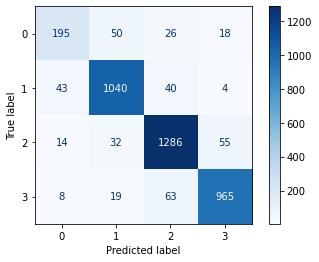

In [56]:
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
Y_pred = model1.predict(X_test_tf)

plot_confusion_matrix(model1,X_test_tf,
                      Y_test, values_format='d',
                      cmap=plt.cm.Blues)


In [57]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['review']).toarray()
print(df_tf.shape)
model2 = LinearSVC(random_state=0, tol=1e-5)
model2.fit(df_tf, df['topic'])
# Cross Validation with 10 folds
scores = cross_val_score(estimator=model1,
                             X=df_tf,
                             y=df['topic'],
                             cv=10)
print ("Validation scores from each iteration of the cross validation ", scores) 
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

(19287, 8784)
Validation scores from each iteration of the cross validation  [0.81130119 0.8750648  0.906169   0.81544842 0.82892691 0.95075168
 0.92534992 0.92479253 0.85684647 0.82002075]
Mean value across of validation scores  0.8714671674313653
Standard deviation of validation scores  0.049677316799200816
